In [1]:
import numpy as np
from sympy import symbols, Matrix
from scipy.integrate import solve_ivp
import scipy.linalg as la
import matplotlib.pylab as plt

In [5]:
tspan = np.linspace(0, 100, 100)

def sortEig(A):
    l, v = la.eig(A)
    idx = np.argsort(np.abs(l))
    l_sorted = l[idx]
    v_sorted = v[:, idx]
    return l_sorted, v_sorted

def ode_system_nonlinear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y
    sum_n345 = n3 + n4 + n5
    CC_A = 1 - sum_n345 / KA
    CC_R = 1 - sum_n345 / KR
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3*CC_A - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4*CC_R - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5*CC_R - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]

def ode_system_linear(t, y, R12, R14, R23, R25, R36, R45, R56, KA, KR, gamma3, gamma4, gamma5, delta):
    n1, n2, n3, n4, n5, P = y
    dn1dt = - (R12 + R14)*n1
    dn2dt = R12*n1 - (R23 + R25)*n2
    dn3dt = R23*n2 - R36*n3 + gamma3*n3 - delta*n3
    dn4dt = R14*n1 - R45*n4 + gamma4*n4 - delta*n4
    dn5dt = R25*n2 + R45*n4 - R56*n5 + gamma5*n5 - delta*n5
    dPdt = (R56*n5 + R36*n3)*(1-P)
    return [dn1dt, dn2dt, dn3dt, dn4dt, dn5dt, dPdt]
# Our Best
N_crypts = 1e+7
r1 = 156
u = 10e-7 * r1
mu = 10e-9 * r1
gamma3 = 0.2
gamma4 = 0.07
gamma5 = 0.07
delta = 0.05
KA = 562
KR = 1780

values = {
    "r1": 156,
    "u": 10e-7 * r1,
    "mu": 10e-9 * r1,
    "R12": 2 * u,
    "R14": mu,
    "R23": u,
    "R25": mu,
    "R36": mu,
    "R45": 2 * u,
    "R56": u,
    "N_crypts": N_crypts,
    "K_A": KA,
    "K_R": KR,
    "gamma_3": gamma3,
    "gamma_4": gamma4,
    "gamma_5": gamma5,
    "delta": delta,
}

def reset_parameters(values_dict):
    global R12, R14, R23, R25, R36, R45, R56, N_crypts, K_A, K_R, gamma_3, gamma_4, gamma_5, delta, u, mu
    r1 = values_dict["r1"]
    u = values_dict["u"]
    mu = values_dict["mu"] 
    R12 = values_dict["R12"]
    R14 = values_dict["R14"]
    R23 = values_dict["R23"]
    R25 = values_dict["R25"]
    R36 = values_dict["R36"]
    R45 = values_dict["R45"]
    R56 = values_dict["R56"]
    N_crypts = values_dict["N_crypts"]
    K_A = values_dict["K_A"]
    K_R = values_dict["K_R"]
    gamma_3 = values_dict["gamma_3"]
    gamma_4 = values_dict["gamma_4"]
    gamma_5 = values_dict["gamma_5"]
    delta = values_dict["delta"]

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data for Gm and Gf
Gm = [
    [57, 16.8, 6.7, 0.6],
    [62, 18.1, 8.3, 1.0],
    [67, 19.2, 9.3, 1.3],
    [72, 19.9, 10.1, 2.0],
    [77, 19.1, 10.5, 2.6],
    [58, 17.9, 7.1, 0.7],
    [63, 19.1, 8.7, 1.1],
    [68, 20.1, 9.7, 1.5],
    [73, 20.6, 10.3, 2.1],
    [78, 19.6, 10.6, 2.7]
]

Gf = [
    [57, 10.1, 3.6, 0.3],
    [62, 11.4, 4.6, 0.5],
    [67, 12.6, 5.4, 0.7],
    [72, 13.7, 6.2, 1.1],
    [77, 13.5, 6.8, 1.6],
    [58, 10.9, 3.9, 0.4],
    [63, 12.2, 4.9, 0.5],
    [68, 13.4, 5.6, 0.8],
    [73, 14.3, 6.4, 1.2],
    [78, 13.9, 7.0, 1.7]
]

# Calculate incidence per age
Gm_data = [[row[0], (row[2] + row[3]) / 100] for row in Gm]
Gf_data = [[row[0], (row[2] + row[3]) / 100] for row in Gf]

# Sort Kadv11 and Kadv21
Gm_data_sort = sorted(Gm_data, key=lambda x: x[0])
GF_data_sort = sorted(Gf_data, key=lambda x: x[0])

# Calculate Kadvave1 and sort it
data = [[x[0], (x[1] + y[1]) / 2] for x, y in zip(Gm_data_sort, GF_data_sort)]
data_sorted = sorted(data, key=lambda x: x[0])

# Extract x and y values for plotting
x_dat = [row[0] for row in data_sorted]
y_dat = [row[1] for row in data_sorted]
#plt.scatter(x_dat,y_dat)

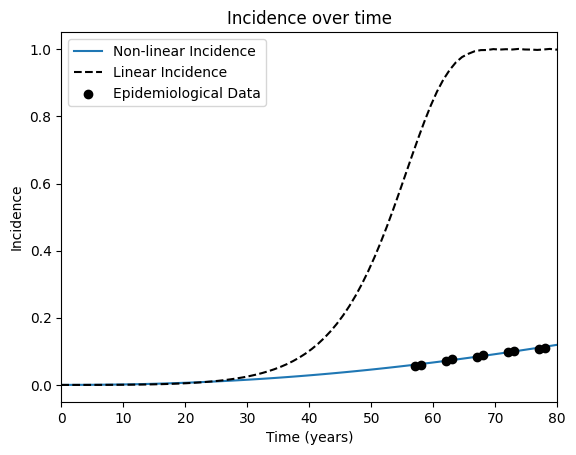

In [8]:
sol = solve_ivp(ode_system_nonlinear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))

sol_0 = solve_ivp(ode_system_linear, [tspan[0], tspan[-1]], y0=[N_crypts, 0, 0, 0, 0, 0], t_eval=tspan, method="RK45",
    args=(2*u, mu, u, mu, mu, 2*u, u, KA, KR, gamma3, gamma4, gamma5, delta))



plt.plot(sol.t-4.97, sol.y[5,:]*(1-delta/1.01199), zorder=1, label='Non-linear Incidence')
plt.plot(sol.t, sol_0.y[5,:], label='Linear Incidence', linestyle='--', color='black')

plt.scatter(x_dat,y_dat,color='k', zorder=2, label='Epidemiological Data')
plt.xlim(0,80)
plt.xlabel('Time (years)')
plt.ylabel('Incidence')
plt.legend(loc='upper left')
plt.title("Incidence over time")
plt.savefig('figures/SimulationIncidenceProbabililty.png')
plt.show()
